- cross-check resulting lexical mappings with cmudict representation
- make sure we don't have overlapping phonemes
- visually check some waveforms and make sure they make sense

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import datasets
import transformers
import logging

logging.basicConfig(level=logging.INFO)

In [2]:
sns.set_theme(style="whitegrid", font_scale=2)

In [3]:
datasets.disable_caching()

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from src.utils import timit

In [6]:
model_name = "facebook/wav2vec2-base"

In [7]:
tokenizer = transformers.Wav2Vec2Tokenizer.from_pretrained("charsiu/tokenizer_en_cmu")
feature_extractor = transformers.Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)
processor = transformers.Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/home/jgauthier/u/transformers/lib/python3.10/site-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:733: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(


In [8]:
raw_corpus = datasets.load_dataset("data/timit_raw")

In [9]:
def prepare_corpus(corpus, drop_phones=("[SIL]", "h#", "epi", "pau")):
    phone_vocab = set(processor.tokenizer.get_vocab().keys())
    # Sanity check: all TIMIT mapped to CMU targets should be in the vocab
    for src, tgt in timit.TIMIT_MAPPING.items():
        if isinstance(tgt, str):
            tgt = [tgt]
        for t in tgt:
            assert t in phone_vocab

    corpus = corpus.map(timit.add_phonemic_detail, batched=False,
                        fn_kwargs=dict(phone_vocab=phone_vocab))

    # Compute phonetic and phonemic details grouped by word span
    corpus = corpus.map(timit.group_phonetic_detail, batched=False, with_indices=True,
                        fn_kwargs=dict(drop_phones=drop_phones))
    corpus = corpus.map(timit.group_phonetic_detail, batched=False, with_indices=True,
                        fn_kwargs=dict(key="phonemic_detail",
                                       drop_phones=drop_phones))
    
    # Add syllabic detail
    corpus = corpus.map(timit.add_syllabic_detail, batched=False)

    # Run sanity checks on updated annotations
    corpus.map(timit.check_item, batched=False, with_indices=True,
               fn_kwargs=dict(drop_phones=drop_phones))
    
    # def prepare_audio(batch):
    #     audio = batch["audio"]
    #     batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    #     return batch
    # corpus = corpus.map(prepare_audio)

    return corpus

In [69]:
log_item = 25
# list(zip(raw_corpus["train"][log_item]["phonetic_detail"]["utterance"],
#          raw_corpus["train"][log_item]["phonetic_detail"]["start"],
#             raw_corpus["train"][log_item]["phonetic_detail"]["stop"]))

In [68]:
# list(zip(raw_corpus["train"][log_item]["word_detail"]["utterance"],
#             raw_corpus["train"][log_item]["word_detail"]["start"],
#                 raw_corpus["train"][log_item]["word_detail"]["stop"]))

In [79]:
dev_corpus = raw_corpus["train"]
dev_corpus = prepare_corpus(dev_corpus)

Map:   0%|          | 0/4620 [00:00<?, ? examples/s]

INFO:src.utils.timit:Interpreting glottal stop as /t/ in item She had your dark suit in greasy wash water all year.: s ux q en gcl
INFO:src.utils.timit:Interpreting glottal stop as /t/ in item A sailboat may have a bone in her teeth one minute and lie becalmed the next.: n ih q ix n
INFO:src.utils.timit:Interpreting glottal stop as /t/ in item A sailboat may have a bone in her teeth one minute and lie becalmed the next.: v ow q m ey
INFO:src.utils.timit:Interpreting glottal stop as /t/ in item The emperor had a mean temper.: dh iy q eh m
INFO:src.utils.timit:Interpreting glottal stop as /t/ in item Critical equipment needs proper maintenance.: w ih q m ix
INFO:src.utils.timit:Interpreting glottal stop as /t/ in item She had your dark suit in greasy wash water all year.: dx axr q aa l
INFO:src.utils.timit:Interpreting glottal stop as /t/ in item She had your dark suit in greasy wash water all year.: s ux q en gcl
INFO:src.utils.timit:Interpreting glottal stop as /t/ in item Receiving no

Map:   0%|          | 0/4620 [00:00<?, ? examples/s]

Map:   0%|          | 0/4620 [00:00<?, ? examples/s]

Map:   0%|          | 0/4620 [00:00<?, ? examples/s]

Map:   0%|          | 0/4620 [00:00<?, ? examples/s]

In [66]:
# list(zip(dev_corpus[log_item]["phonemic_detail"]["utterance"],
#          dev_corpus[log_item]["phonemic_detail"]["start"],
#             dev_corpus[log_item]["phonemic_detail"]["stop"]))

In [80]:
def plot_item(item_idx, ax, plot_dims=None):
    item = dev_corpus[item_idx]

    viz_rate = 1000
    times = np.linspace(0, len(item["input_values"]) / 16000, int(len(item["input_values"]) / 16000 * viz_rate))
    # normalize to [-1, 1]
    values = np.array(item["input_values"])
    values = (values - values.min()) / (values.max() - values.min()) * 2 - 1
    # resample to viz frame rate
    values = np.interp(times, np.arange(len(values)) / 16000, values)
    ax.plot(times, values, alpha=0.2)

    # plot word and phoneme boundaries
    for i, word in enumerate(item["word_phonemic_detail"]):
        word_str = item["word_detail"]["utterance"][i]

        word_start, word_stop = word[0]["start"] / 16000, word[-1]["stop"] / 16000
        ax.axvline(word_start, color="black", linestyle="--")
        ax.text(word_start, -0.8, word_str, rotation=90, verticalalignment="top", alpha=0.7)

        for j, phoneme in enumerate(word):
            phoneme_str = phoneme["phone"]
            phoneme_start, phoneme_stop = phoneme["start"] / 16000, phoneme["stop"] / 16000

            if j > 0:
                color = "black" if phoneme["idx_in_syllable"] == 0 else "gray"
                ax.axvline(phoneme_start, color=color, linestyle=":", alpha=0.5)
            ax.text(phoneme_start + 0.01, -6, phoneme_str, rotation=90, verticalalignment="bottom",
                    fontdict={"size": 15})

    # align at origin
    ax.set_ylim((-8, 8))

    ax.set_title(f"{item['speaker_id']}_{item['id']}: {item['text']}")
    ax.set_yticks([])
    ax.grid(False)
    ax.axis("off")

4532


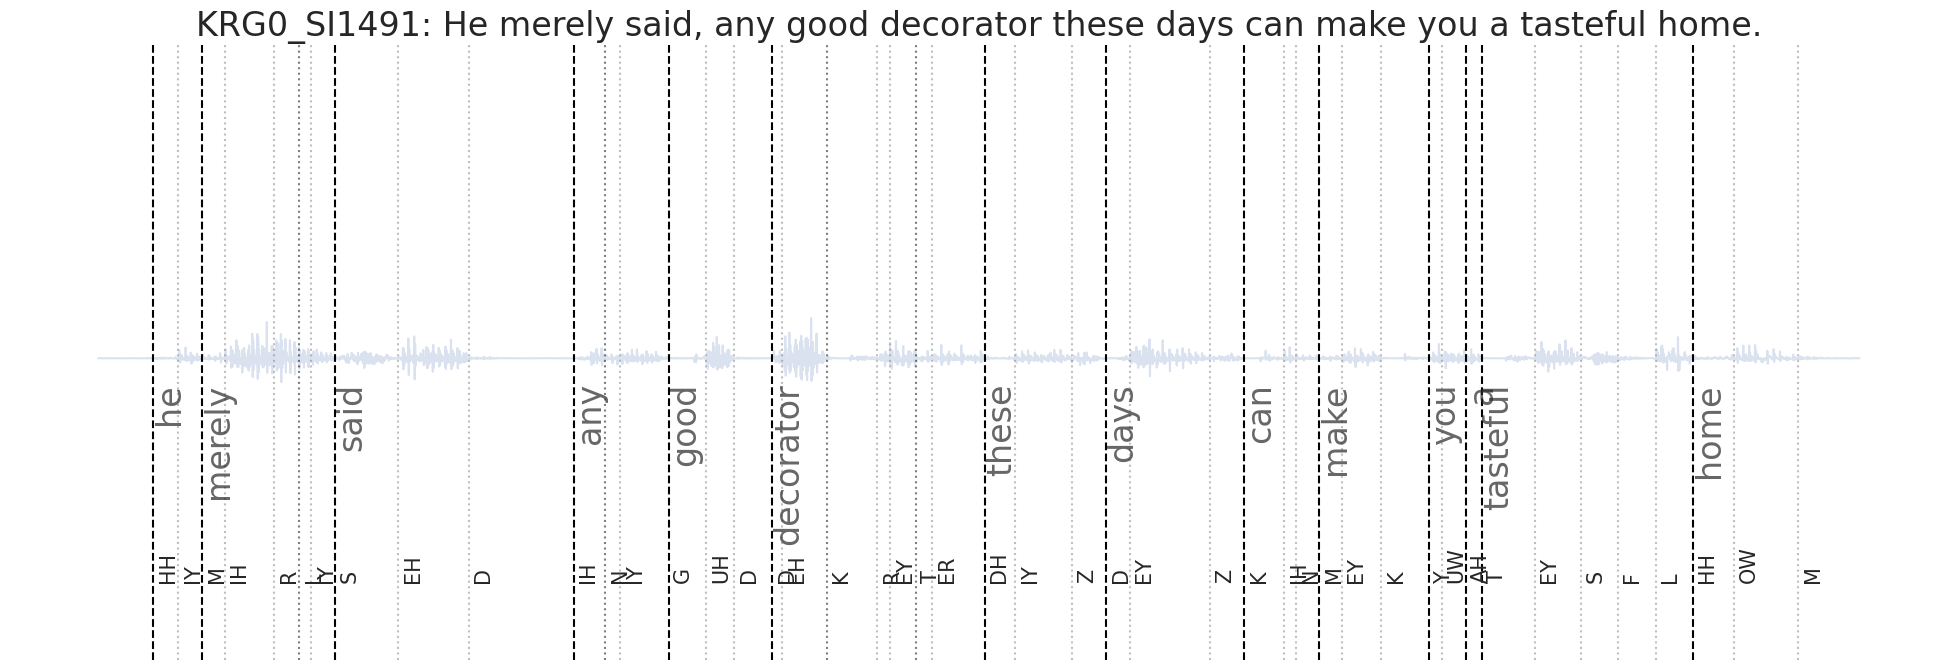

In [85]:
f, ax = plt.subplots(figsize=(25, 8))
idx = np.random.choice(len(dev_corpus))
print(idx)
plot_item(idx, ax)

## Check correspondence with CMUdict

In [ ]:
from tempfile import NamedTemporaryFile
from urllib.request import urlretrieve
import re
from collections import defaultdict

# Download and parse cmudict
cmudict_entries = defaultdict(list)
with NamedTemporaryFile() as f:
    urlretrieve("https://github.com/cmusphinx/cmudict/raw/master/cmudict.dict", f.name)

    with open(f.name, "r") as f:
        for line in f:
            # remove comments
            line = re.sub(r'(\s)*#.*', '', line)

            fields = line.strip().split(" ")
            word = fields[0]

            # remove word idx number, indicating secondary pronunciation
            word = re.sub(r"\(\d\)$", "", word)

            phones = tuple(fields[1:])
            # remove stress markers
            phones = tuple(re.sub(r"\d", "", p) for p in phones)

            cmudict_entries[word].append(phones)


In [ ]:
dev_corpus[0]["phonemic_detail"]["utterance"]

['SH',
 'IH',
 'HH',
 'EH',
 'D',
 'JH',
 'IH',
 'D',
 'AH',
 'K',
 'S',
 'UW',
 'T',
 'AH',
 'N',
 'G',
 'R',
 'IH',
 'S',
 'IH',
 'W',
 'AO',
 'SH',
 '[SIL]',
 'W',
 'AO',
 'T',
 'ER',
 'AO',
 'L',
 'Y',
 'IH',
 'ER']